In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pathlib import Path

path = Path("/kaggle/input/california-boarding/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


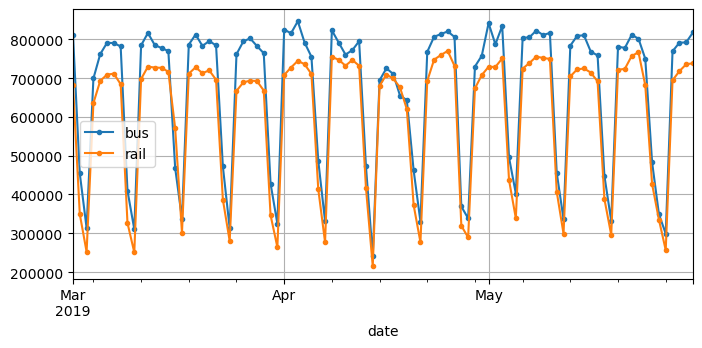

In [5]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

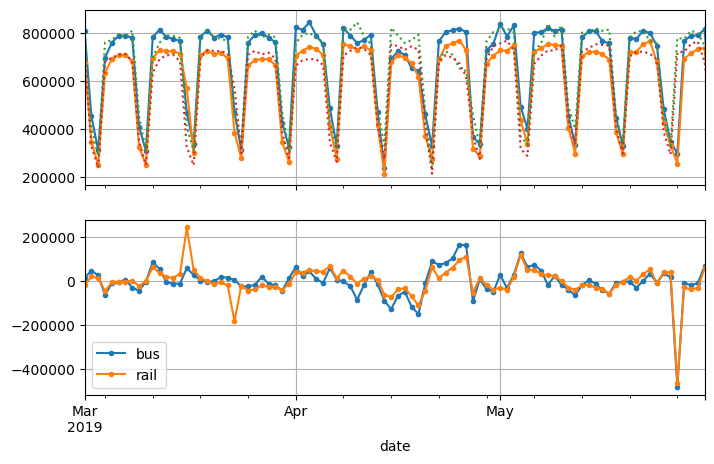

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=axs[1], grid=True, marker=".")
axs[0].set_ylim([170_000, 900_000])
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

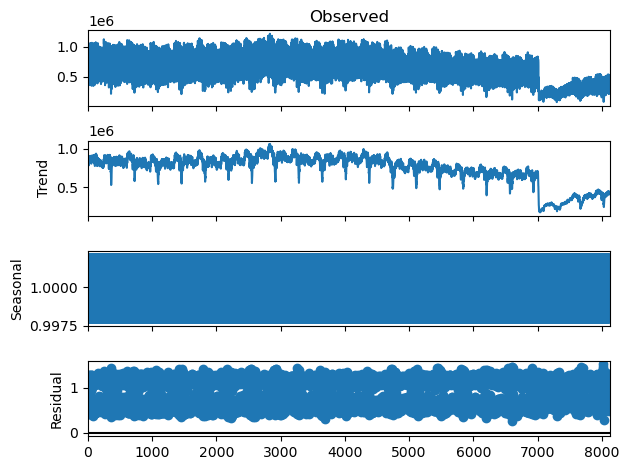

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompse = seasonal_decompose(np.array(df['bus']), 
model='multiplicative', period = 12)
plot = decompse.plot()

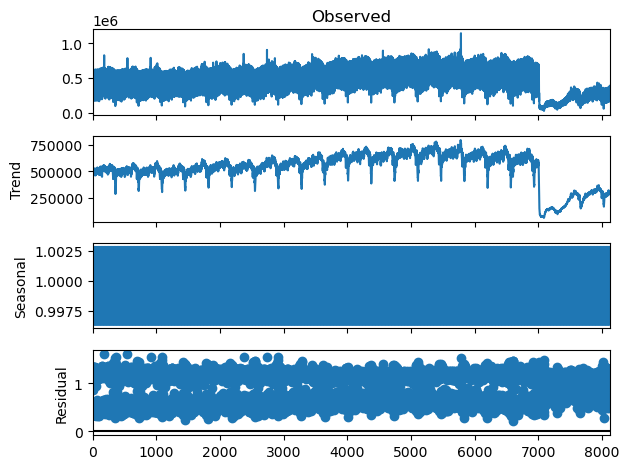

In [11]:
decompse = seasonal_decompose(np.array(df['rail']), 
model='multiplicative', period = 12)
plot = decompse.plot()

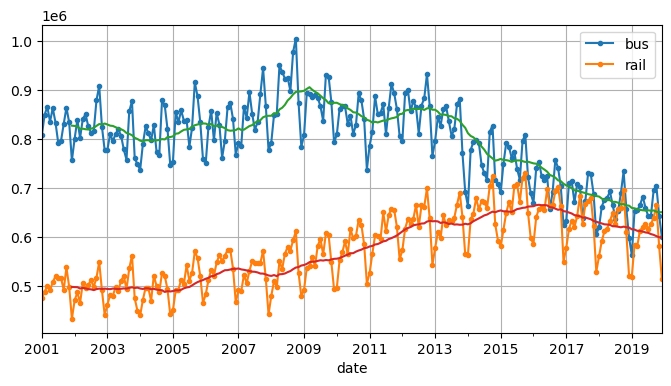

In [12]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

plt.show()

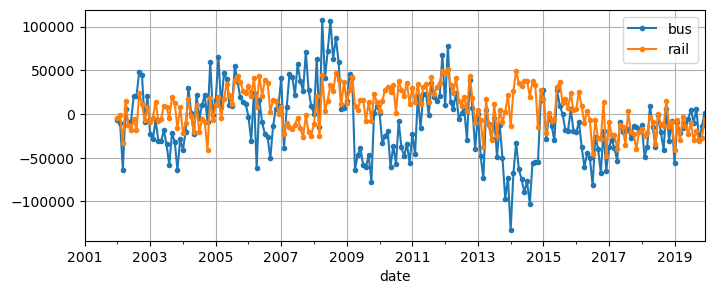

In [13]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [15]:
y_pred[0]

427758.62641035335

In [16]:
df["rail"].loc["2019-06-01"]

379044

In [17]:
df["rail"].loc["2019-05-25"] # naive forecast (value from one week earlier)

426932

In [18]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [19]:
mae

32040.720089453378

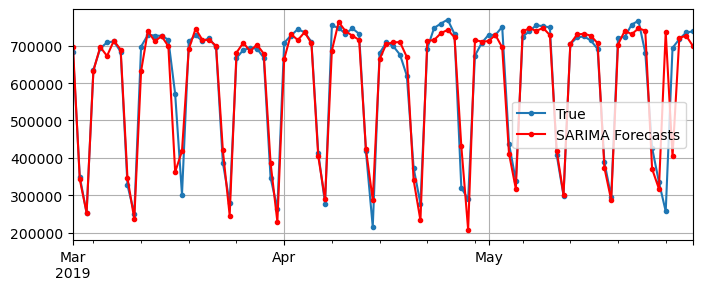

In [20]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

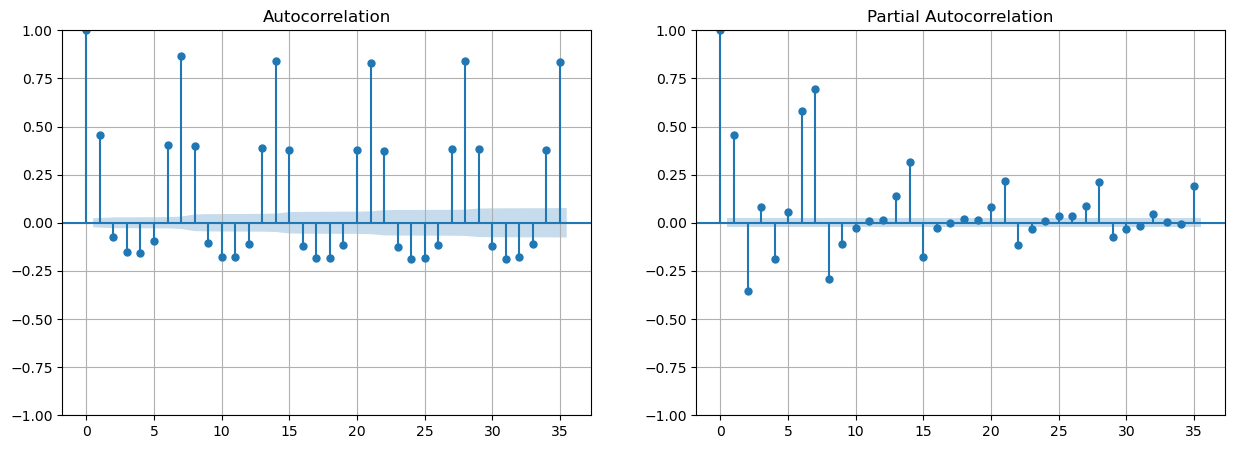

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [22]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [23]:
seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [24]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [25]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [26]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/100
33/33 [==============================] - 2s 25ms/step - loss: 0.0292 - mae: 0.1726 - val_loss: 0.0035 - val_mae: 0.0627
Epoch 2/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0050 - mae: 0.0720 - val_loss: 0.0029 - val_mae: 0.0541
Epoch 3/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0039 - mae: 0.0605 - val_loss: 0.0024 - val_mae: 0.0452
Epoch 4/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0036 - mae: 0.0556 - val_loss: 0.0022 - val_mae: 0.0385
Epoch 5/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0033 - mae: 0.0526 - val_loss: 0.0022 - val_mae: 0.0403
Epoch 6/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0036 - mae: 0.0554 - val_loss: 0.0023 - val_mae: 0.0372
Epoch 7/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0033 - mae: 0.0514 - val_loss: 0.0021 - val_mae: 0.0331
Epoch 8/100
33/33 [==============================] - 1s 16ms/step - loss: 0.

38741.715252399445

In [27]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [28]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/100
33/33 [==============================] - 3s 37ms/step - loss: 0.0521 - mae: 0.2112 - val_loss: 0.0040 - val_mae: 0.0706
Epoch 2/100
33/33 [==============================] - 1s 27ms/step - loss: 0.0056 - mae: 0.0778 - val_loss: 0.0031 - val_mae: 0.0591
Epoch 3/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0048 - mae: 0.0682 - val_loss: 0.0030 - val_mae: 0.0536
Epoch 4/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0047 - mae: 0.0673 - val_loss: 0.0027 - val_mae: 0.0528
Epoch 5/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0040 - mae: 0.0583 - val_loss: 0.0021 - val_mae: 0.0403
Epoch 6/100
33/33 [==============================] - 1s 32ms/step - loss: 0.0037 - mae: 0.0542 - val_loss: 0.0022 - val_mae: 0.0387
Epoch 7/100
33/33 [==============================] - 1s 30ms/step - loss: 0.0036 - mae: 0.0528 - val_loss: 0.0020 - val_mae: 0.0352
Epoch 8/100
33/33 [==============================] - 1s 27ms/step - loss: 0.

38040.67149758339

In [29]:
df_mulvar = df[["bus", "rail"]] / 1e6  
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [30]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [31]:
tf.random.set_seed(42)
seq_length = 56
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  
    targets=mulvar_train[["bus","rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus","rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [32]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

In [33]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/100
33/33 [==============================] - 2s 22ms/step - loss: 0.0569 - mae: 0.2222 - val_loss: 0.0055 - val_mae: 0.0941
Epoch 2/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0034 - mae: 0.0629 - val_loss: 0.0011 - val_mae: 0.0344
Epoch 3/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0023 - mae: 0.0484 - val_loss: 8.3628e-04 - val_mae: 0.0299
Epoch 4/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0019 - mae: 0.0449 - val_loss: 8.6115e-04 - val_mae: 0.0298
Epoch 5/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0018 - mae: 0.0436 - val_loss: 0.0013 - val_mae: 0.0403
Epoch 6/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0017 - mae: 0.0421 - val_loss: 0.0014 - val_mae: 0.0429
Epoch 7/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0019 - mae: 0.0445 - val_loss: 0.0011 - val_mae: 0.0383
Epoch 8/100
33/33 [==============================] - 1s 16ms/step - 

25238.212198019028

In [34]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 25ms/step


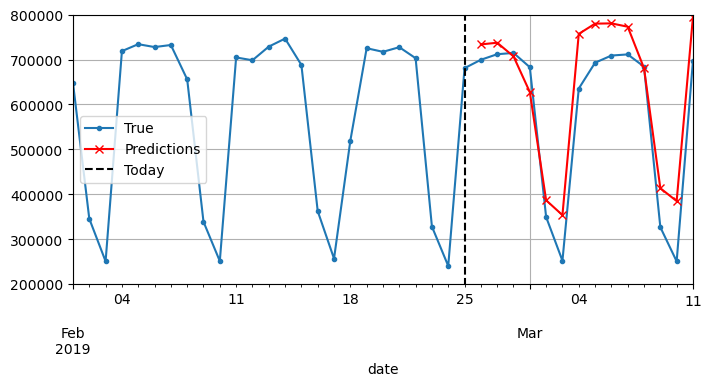

In [35]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [36]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [37]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [38]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/100
33/33 [==============================] - 2s 21ms/step - loss: 0.1013 - mae: 0.3409 - val_loss: 0.0326 - val_mae: 0.2036
Epoch 2/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0226 - mae: 0.1683 - val_loss: 0.0183 - val_mae: 0.1459
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0169 - mae: 0.1473 - val_loss: 0.0148 - val_mae: 0.1318
Epoch 4/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0145 - mae: 0.1371 - val_loss: 0.0128 - val_mae: 0.1224
Epoch 5/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0129 - mae: 0.1288 - val_loss: 0.0114 - val_mae: 0.1154
Epoch 6/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0115 - mae: 0.1206 - val_loss: 0.0097 - val_mae: 0.1080
Epoch 7/100
33/33 [==============================] - 1s 14ms/step - loss: 0.0104 - mae: 0.1139 - val_loss: 0.0085 - val_mae: 0.1028
Epoch 8/100
33/33 [==============================] - 0s 14ms/step - loss: 0.

36544.062197208405

In [39]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [40]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [41]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [42]:
tf.random.set_seed(42) 
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [43]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/100
33/33 [==============================] - 3s 43ms/step - loss: 0.0597 - mae: 0.2498 - val_loss: 0.0152 - val_mae: 0.1354
Epoch 2/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0109 - mae: 0.1128 - val_loss: 0.0083 - val_mae: 0.0927
Epoch 3/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0072 - mae: 0.0865 - val_loss: 0.0065 - val_mae: 0.0769
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0058 - mae: 0.0743 - val_loss: 0.0056 - val_mae: 0.0697
Epoch 5/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0052 - mae: 0.0683 - val_loss: 0.0049 - val_mae: 0.0635
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0049 - mae: 0.0656 - val_loss: 0.0049 - val_mae: 0.0637
Epoch 7/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0046 - mae: 0.0631 - val_loss: 0.0046 - val_mae: 0.0611
Epoch 8/100
33/33 [==============================] - 1s 18ms/step - loss: 0.

47421.91731929779

In [44]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [45]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [46]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=100)

Epoch 1/100
33/33 [==============================] - 3s 43ms/step - loss: 0.0744 - mae: 0.2777 - val_loss: 0.0191 - val_mae: 0.1568
Epoch 2/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0152 - mae: 0.1451 - val_loss: 0.0162 - val_mae: 0.1319
Epoch 3/100
33/33 [==============================] - 1s 30ms/step - loss: 0.0130 - mae: 0.1328 - val_loss: 0.0149 - val_mae: 0.1258
Epoch 4/100
33/33 [==============================] - 1s 30ms/step - loss: 0.0120 - mae: 0.1260 - val_loss: 0.0137 - val_mae: 0.1218
Epoch 5/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0113 - mae: 0.1207 - val_loss: 0.0128 - val_mae: 0.1178
Epoch 6/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0107 - mae: 0.1163 - val_loss: 0.0124 - val_mae: 0.1144
Epoch 7/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0101 - mae: 0.1123 - val_loss: 0.0115 - val_mae: 0.1105
Epoch 8/100
33/33 [==============================] - 1s 31ms/step - loss: 0.

49576.43151283264

In [47]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [48]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/100
33/33 [==============================] - 4s 50ms/step - loss: 0.0600 - mae: 0.2656 - val_loss: 0.0196 - val_mae: 0.1667
Epoch 2/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0178 - mae: 0.1617 - val_loss: 0.0181 - val_mae: 0.1485
Epoch 3/100
33/33 [==============================] - 1s 32ms/step - loss: 0.0161 - mae: 0.1544 - val_loss: 0.0172 - val_mae: 0.1453
Epoch 4/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0154 - mae: 0.1509 - val_loss: 0.0167 - val_mae: 0.1401
Epoch 5/100
33/33 [==============================] - 1s 32ms/step - loss: 0.0148 - mae: 0.1467 - val_loss: 0.0162 - val_mae: 0.1363
Epoch 6/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0142 - mae: 0.1427 - val_loss: 0.0154 - val_mae: 0.1341
Epoch 7/100
33/33 [==============================] - 1s 31ms/step - loss: 0.0136 - mae: 0.1395 - val_loss: 0.0148 - val_mae: 0.1303
Epoch 8/100
33/33 [==============================] - 1s 32ms/step - loss: 0.

71936.41364574432

In [49]:
tf.random.set_seed(42)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [50]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/100
33/33 [==============================] - 4s 64ms/step - loss: 0.0628 - mae: 0.2707 - val_loss: 0.0163 - val_mae: 0.1458
Epoch 2/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0140 - mae: 0.1358 - val_loss: 0.0138 - val_mae: 0.1280
Epoch 3/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0120 - mae: 0.1254 - val_loss: 0.0129 - val_mae: 0.1237
Epoch 4/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0114 - mae: 0.1216 - val_loss: 0.0123 - val_mae: 0.1210
Epoch 5/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0109 - mae: 0.1185 - val_loss: 0.0118 - val_mae: 0.1188
Epoch 6/100
33/33 [==============================] - 1s 32ms/step - loss: 0.0105 - mae: 0.1159 - val_loss: 0.0112 - val_mae: 0.1162
Epoch 7/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0102 - mae: 0.1136 - val_loss: 0.0109 - val_mae: 0.1139
Epoch 8/100
33/33 [==============================] - 1s 33ms/step - loss: 0.

66758.51345062256

In [51]:
tf.random.set_seed(42)
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [52]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1)

Epoch 1/100
31/31 [==============================] - 4s 55ms/step - loss: 0.0534 - mae: 0.2520 - val_loss: 0.0190 - val_mae: 0.1564
Epoch 2/100
31/31 [==============================] - 1s 35ms/step - loss: 0.0165 - mae: 0.1542 - val_loss: 0.0180 - val_mae: 0.1400
Epoch 3/100
31/31 [==============================] - 1s 36ms/step - loss: 0.0148 - mae: 0.1469 - val_loss: 0.0165 - val_mae: 0.1368
Epoch 4/100
31/31 [==============================] - 1s 35ms/step - loss: 0.0137 - mae: 0.1409 - val_loss: 0.0154 - val_mae: 0.1305
Epoch 5/100
31/31 [==============================] - 1s 36ms/step - loss: 0.0126 - mae: 0.1333 - val_loss: 0.0141 - val_mae: 0.1242
Epoch 6/100
31/31 [==============================] - 1s 37ms/step - loss: 0.0114 - mae: 0.1251 - val_loss: 0.0130 - val_mae: 0.1175
Epoch 7/100
31/31 [==============================] - 1s 41ms/step - loss: 0.0103 - mae: 0.1167 - val_loss: 0.0118 - val_mae: 0.1126
Epoch 8/100
31/31 [==============================] - 1s 36ms/step - loss: 0.

50495.66552042961

In [53]:
tf.random.set_seed(42)
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [54]:
wavenet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 32)          352       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)         

In [55]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1)

Epoch 1/100
31/31 [==============================] - 4s 57ms/step - loss: 0.0642 - mae: 0.2826 - val_loss: 0.0216 - val_mae: 0.1618
Epoch 2/100
31/31 [==============================] - 1s 32ms/step - loss: 0.0167 - mae: 0.1575 - val_loss: 0.0185 - val_mae: 0.1533
Epoch 3/100
31/31 [==============================] - 1s 31ms/step - loss: 0.0160 - mae: 0.1562 - val_loss: 0.0182 - val_mae: 0.1517
Epoch 4/100
31/31 [==============================] - 1s 31ms/step - loss: 0.0156 - mae: 0.1543 - val_loss: 0.0178 - val_mae: 0.1497
Epoch 5/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0151 - mae: 0.1512 - val_loss: 0.0171 - val_mae: 0.1448
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 0.0143 - mae: 0.1453 - val_loss: 0.0160 - val_mae: 0.1383
Epoch 7/100
31/31 [==============================] - 1s 31ms/step - loss: 0.0131 - mae: 0.1367 - val_loss: 0.0148 - val_mae: 0.1291
Epoch 8/100
31/31 [==============================] - 1s 30ms/step - loss: 0.

55840.48107266426